## makemore -- mlp

following andrej karpathy's course (https://www.youtube.com/watch?v=TCH_1BHY58I)

his github: https://github.com/karpathy/makemore

### high level

this is a *word* level language model, and has a defined vocabulary size of *n* words. Each word is represented with a vector embedding.

predict the next word given the previous word. works by tuning the embedding vectors over time.

# <img src="./images/mlp.png" width="500" style="margin: 0 auto; display: block;"/>

- predict next word using 3 previous words
- *n-1* indices
- lookup table *C* is a *n x d* matrix, where *d* is the embedding dimension (30 in this case) -> first layer has *3 x 30* neurons
- hidden layer: tanh - its a hyperparameter (design choice upto designer of neural net), can be as large or small as one wants, but each neuron here connected to all the neurons in the prev layer + next layer
- output layer: *n* neurons, one for each word in the vocabulary

In [2]:
!curl -O https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt
!pip install torch

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  222k  100  222k    0     0   461k      0 --:--:-- --:--:-- --:--:--  461k

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

words = open('names.txt', 'r').read().splitlines()

In [4]:
# building the vocab

chars = sorted(list(set("".join(words))))
stoi = {c: i + 1 for i, c in enumerate(chars)}
stoi['.'] = 0
itos = {i: c for c, i in stoi.items()}
print(itos)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# building the dataset. taking three chars at a time, and assigning the output label as the fourth char

block_size = 3 # context length
X, Y = [], []

for word in words:
    context = [0] * block_size
    # print(word)
    for ch in word + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # the example
        # print(f'{"".join(itos[i] for i in context)} -> {ch}')
        context = context[1:] + [ix]
    # print()

X = torch.tensor(X)
Y = torch.tensor(Y)

X.shape, Y.shape # each input to the neural net is 3 integers, and we have 228146 examples in total

(torch.Size([228146, 3]), torch.Size([228146]))

we now construct the lookup table *C*. shape will be *e x c x d* where *e* is the number of examples, *c* is the context length, and *d* is the embedding dimension

In [6]:
C = torch.randn((27, 2)) # 27 chars in the vocab, and each word is represented with a 2 dimensional vector
emb = C[X] # get all embeddings for the input simultaneously
emb.shape

torch.Size([228146, 3, 2])

we now construct the hidden layer

In [7]:
W1 = torch.randn((6, 100)) # 6 inputs to each neuron (3 words x 2 embedding dimensions) and 100 neurons in total (our choice)
b1 = torch.randn((100))

In [9]:
# do a little preprocessing to make matmul possible
# concatenate embeddings for each element in context
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1)

# the code below does the same thing elegantly, however not elegant from a memory/performance perspective because it creates a new tensor and copies the data
torch.cat(torch.unbind(emb, dim=1), dim=1)

# the code below does it even more elegantly, and does not create a new tensor, just modifies internal "view" of the tensor
# to see why, call tensor.storage() to see the internal storage of the tensor
emb.view(228146, 6)


tensor([[ 0.1914,  1.5548,  0.1914,  1.5548,  0.1914,  1.5548],
        [ 0.1914,  1.5548,  0.1914,  1.5548,  0.6183, -0.2377],
        [ 0.1914,  1.5548,  0.6183, -0.2377, -0.1099,  0.3770],
        ...,
        [-1.5670,  0.5186, -1.5670,  0.5186,  1.4808,  0.1691],
        [-1.5670,  0.5186,  1.4808,  0.1691, -1.5670,  0.5186],
        [ 1.4808,  0.1691, -1.5670,  0.5186, -0.3105,  0.0749]])

In [10]:
# hidden state
# -1 is a wildcard dimension, and will be inferred from the context
h = emb.view(-1, 6) @ W1 + b1
h

tensor([[-0.4475,  1.9924,  0.6622,  ..., -0.1144,  2.9397, -1.9564],
        [-3.2015, -0.0404,  1.4197,  ..., -0.2020,  1.6433, -0.1317],
        [-2.3699, -0.4051,  1.8035,  ..., -0.5019,  2.2332, -0.1407],
        ...,
        [-1.7717,  3.8124, -0.6391,  ...,  0.0692,  0.3260,  1.0467],
        [-1.3222,  7.1545,  5.1360,  ...,  4.1333,  1.7018, -1.5121],
        [-0.5013,  0.2270, -3.4133,  ..., -2.2719,  1.8085,  1.1462]])

output layer

In [11]:
# 100 inputs to each neuron, and 27 neurons in total (one for each char)
W2 = torch.randn((100, 27))
b2 = torch.randn((27))

logits = h @ W2 + b2
logits.shape

torch.Size([228146, 27])

In [12]:
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdim=True)
loss = -probs[torch.arange(probs.shape[0]), Y].log().mean()

# cross entropy loss gives the same output
# better because torch does not do the intermediate steps above and create unnecessary tensors
# does clustered mathematical operations

ce_loss = F.cross_entropy(logits, Y)

summary before training nn

In [13]:
params = [C, W1, b1, W2, b2]
sum(p.nelement() for p in params)

3481

run the backward pass

In [21]:
for p in params:
    p.requires_grad = True

for _ in range(100):
    # running minibatches here to save time
    # the gradient is less accurate since # of examples is small but accurate enough
    ix = torch.randint(0, X.shape[0], (32,))

    # FORWARD PASS
    emb = C[X[ix]]
    # to introduce non-linearity, ensuring that the network is not a linear function at the end of the day
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])

    # BACKWARD PASS
    for p in params:
        p.grad = None
    loss.backward()

    # UPDATE WEIGHTS
    for p in params:
        p.data += -0.1 * p.grad
    print(loss.item())    

2.4600377082824707
3.104323387145996
3.1737775802612305
2.6484925746917725
3.2979588508605957
3.6492831707000732
3.3040995597839355
3.1140024662017822
2.740424633026123
3.0305724143981934
3.4884085655212402
3.2311062812805176
2.9548306465148926
2.660472869873047
3.0614099502563477
3.94095516204834
3.3746044635772705
2.9299538135528564
3.04174542427063
3.1397104263305664
2.887321710586548
3.1168975830078125
3.442455768585205
2.820298671722412
2.6438181400299072
3.1772007942199707
2.4337053298950195
3.1072397232055664
3.2830398082733154
2.8309073448181152
2.7816877365112305
2.921694755554199
2.977997303009033
2.9163732528686523
2.8695032596588135
3.1685984134674072
3.126270055770874
3.2000675201416016
3.5015876293182373
2.985619068145752
3.1135785579681396
2.715890884399414
2.8458659648895264
2.7271854877471924
3.503573179244995
3.095801830291748
3.072004795074463
2.8937039375305176
3.047506809234619
3.0329902172088623
2.9110326766967773
2.9633591175079346
2.6178746223449707
3.3447012901

In [22]:
emb = C[X[ix]]
# to introduce non-linearity, ensuring that the network is not a linear function at the end of the day
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y[ix])
loss

tensor(2.8650, grad_fn=<NllLossBackward0>)

loss analysis -- how do we choose the best learning rate?

In [88]:
# reset cell
C = torch.randn((27, 2))
W1 = torch.randn((6, 100))
b1 = torch.randn((100))
W2 = torch.randn((100, 27))
b2 = torch.randn((27))
params = [C, W1, b1, W2, b2]

In [24]:
# construct a list (1000 elements) of learning rates from 10^-3 to 1 to try
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [33]:
lri = []
lossi = []
lri_exp = []

for p in params:
    p.requires_grad = True

for i in range(1000):
    # running minibatches here to save time
    # the gradient is less accurate since # of examples is small but accurate enough
    ix = torch.randint(0, X.shape[0], (32,))

    # FORWARD PASS
    emb = C[X[ix]]
    # to introduce non-linearity, ensuring that the network is not a linear function at the end of the day
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])

    # BACKWARD PASS
    for p in params:
        p.grad = None
    loss.backward()

    # UPDATE WEIGHTS
    lr = lrs[i]
    for p in params:
        p.data += -lr * p.grad
    print(loss.item())

    # TRACKING
    lri.append(lr)
    lri_exp.append(lre[i])
    lossi.append(loss.item())


8.928792953491211
9.36701774597168
8.851469993591309
10.541481018066406
7.460205078125
8.498467445373535
7.8822126388549805
9.39392375946045
7.350952625274658
10.53848934173584
10.662015914916992
11.610064506530762
7.910185813903809
10.334081649780273
10.028605461120605
10.915284156799316
9.625700950622559
9.025558471679688
9.029848098754883
8.723126411437988
9.511910438537598
10.774441719055176
8.941990852355957
11.061979293823242
8.767542839050293
8.527199745178223
10.299567222595215
8.136959075927734
10.581303596496582
11.453664779663086
9.049050331115723
12.147244453430176
6.781136989593506
9.779471397399902
9.347746849060059
8.405261039733887
9.88129997253418
8.125697135925293
11.062077522277832
10.267866134643555
9.415790557861328
8.944095611572266
7.6231842041015625
9.22427749633789
10.01810359954834
10.23548698425293
8.625401496887207
8.354990005493164
11.80047607421875
10.164826393127441
8.7105073928833
8.198148727416992
11.067312240600586
6.669773101806641
9.306999206542969
8

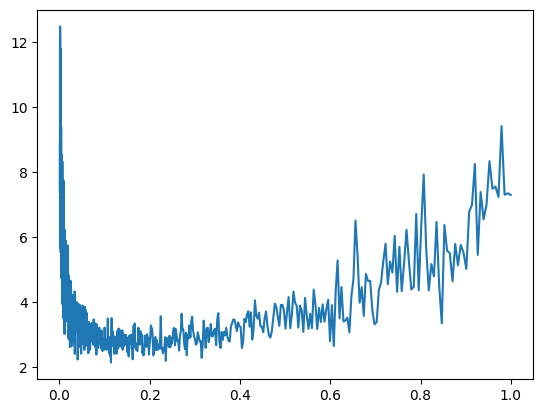

In [36]:
from matplotlib import pyplot as plt

plt.plot(lri, lossi)

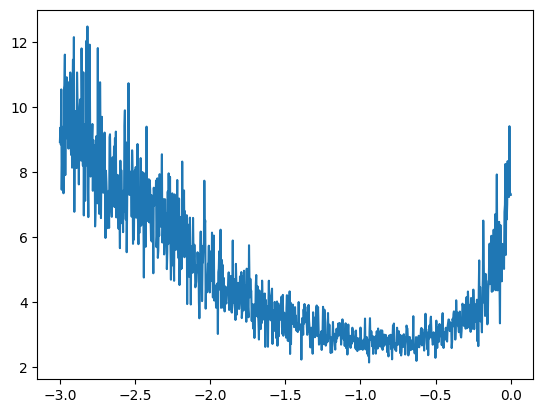

In [35]:
plt.plot(lri_exp, lossi)

so 10^-0.7 seems to be a nice spot

### test/train/validation split

80% - training set
10% - validation set (to tune hyperparams like the number of neurons in hidden layer, learning rate, etc)
10% - test set (to test the final model)

In [38]:
# building the dataset. taking three chars at a time, and assigning the output label as the fourth char

def build_dataset(words):
    block_size = 3 # context length
    X, Y = [], []

    for word in words:
        context = [0] * block_size
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtrain, Ytrain = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

In [106]:
def train(X, Y, dim=2, context=3):
    lossi = []
    stepi = []
    
    for p in params:
        p.requires_grad = True

    for i in range(10000):
        # running minibatches here to save time
        # the gradient is less accurate since # of examples is small but accurate enough
        ix = torch.randint(0, X.shape[0], (32,))

        # FORWARD PASS
        emb = C[X[ix]]
        # to introduce non-linearity, ensuring that the network is not a linear function at the end of the day
        h = torch.tanh(emb.view(-1, context * dim) @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Y[ix])

        # BACKWARD PASS
        for p in params:
            p.grad = None
        loss.backward()

        # UPDATE WEIGHTS
        for p in params:
            p.data += -0.1 * p.grad
        print(loss.item())

        # TRACKING
        stepi.append(i)
        lossi.append(loss.item())

    return lri, lossi, lri_exp, stepi

since training loss is similar to validation loss, the model is underfitting and we could do better with more params

In [109]:
def check_loss(X, Y, dim=2, context=3):
    emb = C[X]
    h = torch.tanh(emb.view(-1, context * dim) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    return loss.item()

In [93]:
# reset cell with new params
C = torch.randn((27, 2))
W1 = torch.randn((6, 300))
b1 = torch.randn((300))
W2 = torch.randn((300, 27))
b2 = torch.randn((27))
params = [C, W1, b1, W2, b2]
sum(p.nelement() for p in params)

10281

In [94]:
lri, lossi, lri_exp, stepi = train(Xtrain, Ytrain)
check_loss(Xval, Yval)

29.421585083007812
25.08441162109375
22.367095947265625
22.289390563964844
19.32517433166504
19.26700782775879
19.608726501464844
23.937410354614258
15.241692543029785
17.58231544494629
18.995319366455078
17.016443252563477
10.311012268066406
16.083372116088867
11.963515281677246
11.156545639038086
8.484757423400879
13.076135635375977
10.731656074523926
11.822994232177734
12.207935333251953
8.978829383850098
10.223128318786621
12.215367317199707
11.03403091430664
9.94383716583252
9.091395378112793
10.191119194030762
8.290910720825195
10.113723754882812
7.766911029815674
8.99936580657959
8.854424476623535
7.271334171295166
10.00641918182373
5.602537155151367
8.611705780029297
9.06901741027832
10.190742492675781
5.3711395263671875
7.791720390319824
9.047964096069336
8.758269309997559
9.541437149047852
8.459609031677246
7.407617092132568
7.656883239746094
8.340210914611816
7.289881706237793
7.047205448150635
7.679084777832031
5.61384391784668
8.314535140991211
6.032484531402588
7.10760545

2.6815297603607178

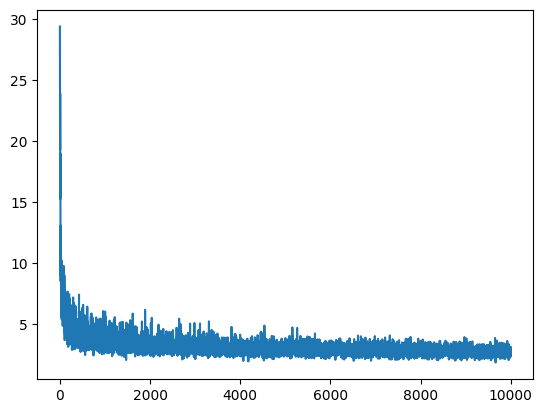

In [95]:
plt.plot(stepi, lossi)

lets take a look at the embeddings

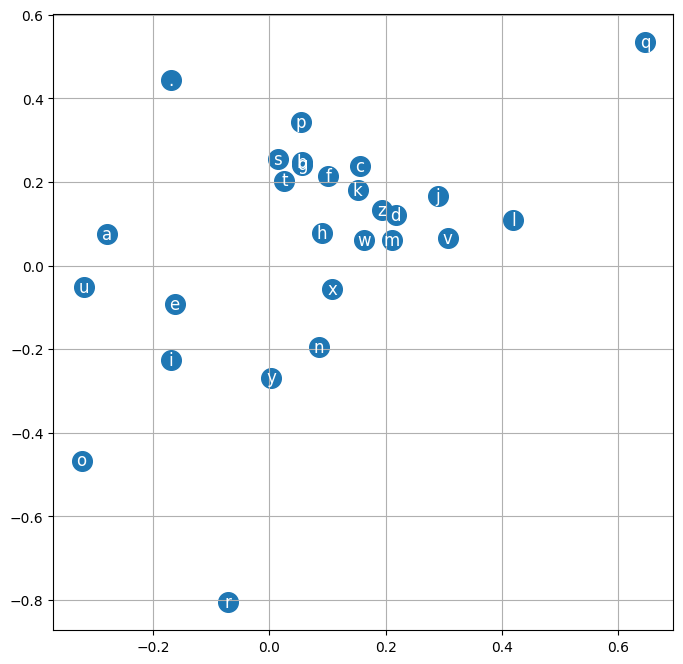

In [102]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].data, C[i, 1].data, itos[i], ha="center", va="center", fontsize=12, color="white")
plt.grid("minor")


notice how the model learnt that vowels are similar by clustering them together

the model is also not learning effectively enough because the number of dimensions is too small.

In [103]:
# reset cell with new params
C = torch.randn((27, 10)) # now 10 dimensions
W1 = torch.randn((30, 200)) # 3 * 10 dimensions -> 30
b1 = torch.randn((200))
W2 = torch.randn((200, 27)) # reduced hidden layer neurons
b2 = torch.randn((27))
params = [C, W1, b1, W2, b2]
sum(p.nelement() for p in params)

11897

2.5104169845581055
2.322580099105835
2.4819529056549072
2.23842716217041
2.4883296489715576
2.5598013401031494
2.6432154178619385
2.0239498615264893
2.7309346199035645
2.0603220462799072
2.2480523586273193
2.7492103576660156
2.4100325107574463
2.624920606613159
2.3724255561828613
2.6977148056030273
2.863992691040039
1.957808017730713
2.536923408508301
2.561781406402588
2.7883598804473877
2.3550872802734375
2.470813035964966
2.4483327865600586
2.234541654586792
2.538926362991333
2.5787301063537598
2.9896609783172607
3.030374765396118
2.2513341903686523
2.9623947143554688
2.6427581310272217
3.006476879119873
2.4954991340637207
2.588642120361328
2.516005277633667
2.4831671714782715
3.0377719402313232
2.9449901580810547
2.8117706775665283
2.4791862964630127
2.3849971294403076
2.4178857803344727
2.6556921005249023
2.4217631816864014
2.4411990642547607
2.3816094398498535
2.5671639442443848
2.4407246112823486
2.7173678874969482
2.589169979095459
2.5875868797302246
2.6218314170837402
2.5307164

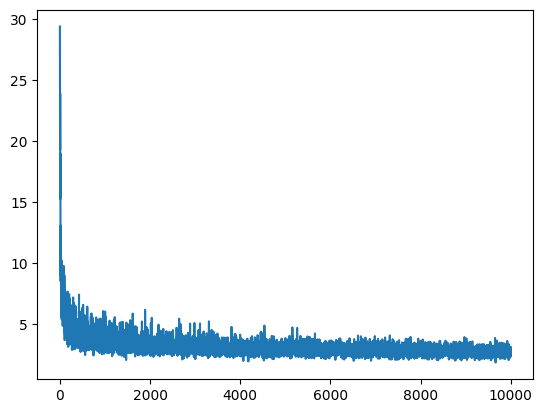

In [ ]:
train(Xtrain, Ytrain, dim=10, context=3)
plt.plot(stepi, lossi)

In [112]:
check_loss(Xval, Yval, dim=10, context=3)


2.467560291290283

sampling from the model

In [ ]:
for _ in range(5):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([scontext])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(itos[ix])
        if ix == 0:
            break

    print("".join(out))
        

viel.
sadia.
tanie.
haminen.
vevin.
